In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [4]:
print("Num GPus Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPus Available:  0


### Model Training Using Generated Data

In [5]:
df = pd.read_csv(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\Data\generated_df.csv')

In [6]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.124115,-1.599393,-0.149914,2.109682,0.038543,0.595675,0.644721,0.317964,-0.369205,1.019132,...,-0.249379,0.298205,0.246104,-0.714229,-0.171008,0.274035,-0.646160,-0.378601,-0.306242,0
1,-0.140221,-0.077036,0.114725,-0.068618,0.045462,-0.106829,0.094702,-0.111777,-0.072793,-0.062311,...,-0.019231,-0.002653,0.107842,-0.052991,-0.230395,-0.069105,-0.124035,-0.172561,-0.072274,1
2,-0.947813,-3.226223,-3.263305,-1.845165,0.003520,-4.396491,1.738821,5.760154,-0.029454,-0.901879,...,0.983785,0.114422,3.552622,-0.124398,0.141898,0.793311,-0.359761,0.257221,5.835037,0
3,0.521871,1.874811,-0.451824,-1.223864,0.202895,0.597169,1.184379,-0.439232,0.323480,0.519073,...,0.433782,1.543418,-0.054433,-1.532265,-0.004131,0.728989,0.002979,-0.084599,-0.256801,0
4,-1.136310,-1.142740,1.468732,0.241103,0.625281,0.338581,0.776647,-0.039810,0.842324,-0.265041,...,0.089044,0.369480,-0.235014,-1.353952,0.013564,-0.087556,0.501524,0.251930,-0.319940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368721,1.360712,0.149260,0.988698,-0.605170,-0.788264,1.238822,-0.203064,0.861209,0.067349,-0.279204,...,-0.326673,-0.816542,0.008957,-0.010456,-0.377837,0.128193,0.219217,0.068558,-0.349773,0
368722,-0.144409,-0.056656,0.148645,-0.104169,0.046285,-0.127849,-0.003682,-0.101806,-0.062445,-0.060322,...,0.030523,-0.052311,0.109520,-0.045674,-0.214116,-0.088019,-0.053956,-0.185627,-0.087897,1
368723,-0.312295,1.259310,-0.049484,-0.721776,0.071903,1.864771,3.635628,-0.821682,0.929256,0.128685,...,0.070189,0.104264,-0.107993,1.004823,0.674600,-0.275199,0.045933,0.025074,-0.335356,0
368724,-0.132160,1.982903,-0.134427,-1.161183,0.472515,-0.043755,-1.080473,0.306983,-0.373167,0.454594,...,-0.212230,-0.472417,0.248672,0.025584,-0.195097,0.272711,-0.071660,-0.055715,-0.195658,0


In [7]:
df['Class'].value_counts()

Class
0    283253
1     85473
Name: count, dtype: int64

In [8]:
fraud = df[df['Class']==1]
genuine = df[df['Class']==0]

In [10]:
legit = genuine.sample(199437)

In [12]:
df_balanced = pd.concat([fraud,legit])
df_balanced = df_balanced.sample(frac=1, random_state=42)

In [13]:
df_balanced['Class'].value_counts()

Class
0    199437
1     85473
Name: count, dtype: int64

In [14]:
df_balanced.to_csv(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\Data\Dataset03.csv') 

In [15]:
df_balanced = pd.read_csv(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\Data\Dataset03.csv')

In [16]:
df_balanced = df_balanced.drop('Unnamed: 0',axis=1)

In [17]:
features = df_balanced.drop('Class',axis=1)
target = df_balanced['Class']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state=42)

In [19]:
X_train.shape,X_test.shape

((199437, 30), (85473, 30))

#### Logistic Regression Model

In [20]:
#the hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter':[1000,2000,5000]
}

In [21]:
# Create a GridSearchCV object
gscv = GridSearchCV(LogisticRegression(), param_grid, cv=5)

In [22]:
# Fit the GridSearchCV object to the training data
gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [1000, 2000, 5000],
                         'solver': ['liblinear', 'lbfgs']})

In [23]:
best_params = gscv.best_params_

In [24]:
lgt = LogisticRegression(**best_params)
lgt.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')

In [25]:
y_pred = lgt.predict(X_test)

In [26]:
accuracy_lgt = accuracy_score(y_test, y_pred)
precision_lgt = precision_score(y_test, y_pred)
recall_lgt = recall_score(y_test, y_pred)
f1_score_lgt = f1_score(y_test, y_pred)
mcc_lgt = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy_lgt)
print("Precision:", precision_lgt)
print("Recall:", recall_lgt)
print("F1-score:", f1_score_lgt)
print("MCC:", mcc_lgt)

Accuracy: 0.934341838943292
Precision: 0.8692003225097119
Recall: 0.9206909937888199
F1-score: 0.8942050295969537
MCC: 0.8473993785182331


In [27]:
cm_logit = confusion_matrix(y_test, y_pred)
print(cm_logit)

[[56144  3569]
 [ 2043 23717]]


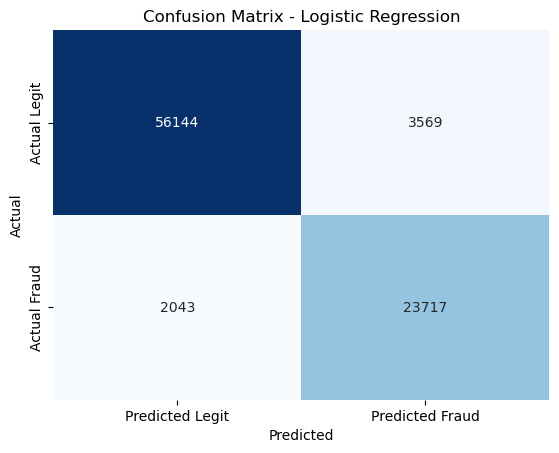

In [29]:
sns.heatmap(cm_logit, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Legit", "Predicted Fraud"],
            yticklabels=["Actual Legit", "Actual Fraud"])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### SVM Model

In [52]:
param_grid_svm = {'C': [1, 10,100],  
              'gamma': [1, 0.1, 0.01], 
              } 

In [53]:
# Create a GridSearchCV object
gscv_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)

In [54]:
gscv_svm.fit(X_train, y_train) 

: 

In [ ]:
best_params_svm = gscv_svm.best_params_

In [28]:
svm = SVC(C=100, gamma=0.001)

svm.fit(X_train, y_train)

SVC(C=100, gamma=0.001)

In [30]:
y_pred_svm = svm.predict(X_test)

In [32]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_score_svm = f1_score(y_test, y_pred_svm)
mcc_svm = matthews_corrcoef(y_test, y_pred_svm)

print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-score:", f1_score_svm)
print("MCC:", mcc_svm)

Accuracy: 0.9994618183519942
Precision: 0.9996114090308541
Recall: 0.9986024844720497
F1-score: 0.9991066920417913
MCC: 0.9987218609853105


In [33]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

[[59703    10]
 [   36 25724]]


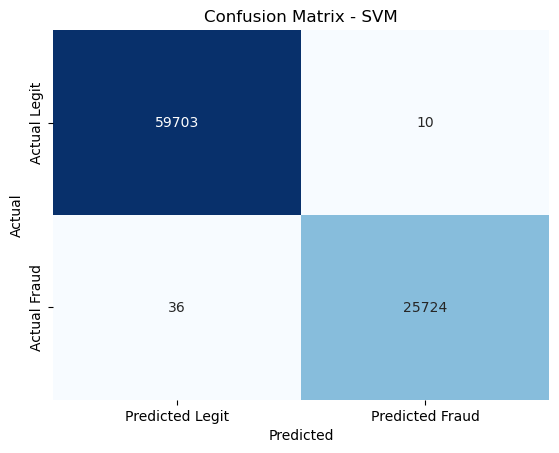

In [34]:
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Legit", "Predicted Fraud"],
            yticklabels=["Actual Legit", "Actual Fraud"])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Decision Tree

In [35]:
dtree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=10)

dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=10)

In [36]:
y_pred_dtree = dtree.predict(X_test)

In [37]:
accuracy_dtree = accuracy_score(y_test, y_pred_dtree)
precision_dtree = precision_score(y_test, y_pred_dtree)
recall_dtree = recall_score(y_test, y_pred_dtree)
f1_score_dtree = f1_score(y_test, y_pred_dtree)
mcc_dtree = matthews_corrcoef(y_test, y_pred_dtree)

print("Accuracy:", accuracy_dtree)
print("Precision:", precision_dtree)
print("Recall:", recall_dtree)
print("F1-score:", f1_score_dtree)
print("MCC:", mcc_dtree)

Accuracy: 0.9951680647689913
Precision: 0.9970584774679374
Recall: 0.9868788819875777
F1-score: 0.9919425639424858
MCC: 0.9885186281373735


In [38]:
cm_dt = confusion_matrix(y_test, y_pred_dtree)
print(cm_dt)

[[59638    75]
 [  338 25422]]


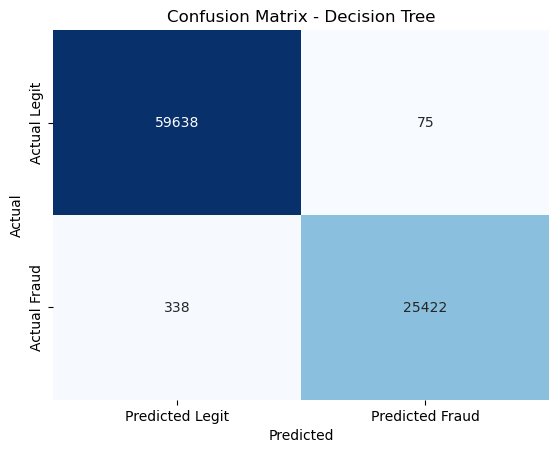

In [71]:
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Legit", "Predicted Fraud"],
            yticklabels=["Actual Legit", "Actual Fraud"])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### CNN

In [42]:
X_test1 = X_test
y_test1 = y_test
X_train1 =X_train
y_train1 = y_train

In [43]:
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)

In [44]:
X_train3 = X_train1.to_numpy()
y_train3 = y_train1.to_numpy()
X_val3 = X_val2.to_numpy()
y_val3 = y_val2.to_numpy()
X_test3 = X_test2.to_numpy()
y_test3 = y_test2.to_numpy()

In [46]:
X_train3= X_train3.reshape(X_train3.shape[0],X_train3.shape[1],1)
X_test3 = X_test3.reshape(X_test3.shape[0],X_test3.shape[1],1)
X_train3.shape, X_test3.shape,X_val3.shape

((199437, 30, 1), (42737, 30, 1), (42736, 30))

In [47]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv1D,BatchNormalization,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner
from tensorflow import keras
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


In [48]:
#import model
model=Sequential()

In [49]:
def build_model(hp):
  model = keras.Sequential([
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [1,3,5]),
        activation='relu',
        input_shape= (X_train1.shape[1],1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv1D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [1,3,5]),
        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  model.build()

  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model


In [50]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='D:/Uni Docs/DSC4996/Dynamic_fraud_detection_system/CNN_output',project_name="Hyperparameter Tuning of CNN")

'''tuner = keras_tuner.RandomSearch(
    build_model, 
    objective='val_loss',
    max_trials=5)'''

Reloading Tuner from D:/Uni Docs/DSC4996/Dynamic_fraud_detection_system/CNN_output\Hyperparameter Tuning of CNN\tuner0.json


"tuner = keras_tuner.RandomSearch(\n    build_model, \n    objective='val_loss',\n    max_trials=5)"

In [51]:
tuner.search(X_train3, y_train3, epochs=20, validation_data= (X_val3, y_val3),input_shape = (X_train1.shape[1],1))
#tuner.search(X_train1, y_train1, epochs=20, validation_split = 0.1)

In [52]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [53]:
cnn_best = tuner.hypermodel.build(best_hps)

In [54]:
cnn1 = cnn_best.fit(X_train3, y_train3, epochs = 100, validation_data = (X_val3, y_val3))

Epoch 1/100
6233/6233 [==============================] - 35s 5ms/step - loss: 0.0278 - accuracy: 0.9981 - val_loss: 0.0087 - val_accuracy: 0.9987
Epoch 2/100
6233/6233 [==============================] - 34s 5ms/step - loss: 0.0164 - accuracy: 0.9984 - val_loss: 0.0088 - val_accuracy: 0.9988
Epoch 3/100
6233/6233 [==============================] - 34s 6ms/step - loss: 0.0158 - accuracy: 0.9983 - val_loss: 0.0306 - val_accuracy: 0.9982
Epoch 4/100
6233/6233 [==============================] - 34s 6ms/step - loss: 0.0145 - accuracy: 0.9983 - val_loss: 0.0136 - val_accuracy: 0.9986
Epoch 5/100
6233/6233 [==============================] - 34s 5ms/step - loss: 0.0227 - accuracy: 0.9985 - val_loss: 0.0801 - val_accuracy: 0.9993
Epoch 6/100
6233/6233 [==============================] - 33s 5ms/step - loss: 0.0184 - accuracy: 0.9981 - val_loss: 0.0131 - val_accuracy: 0.9986
Epoch 7/100
6233/6233 [==============================] - 34s 5ms/step - loss: 0.0153 - accuracy: 0.9982 - val_loss: 0.0199 -

In [ ]:
#best_model=tuner.get_best_models(num_models=1)[0]
#best_model(X_train1)

In [55]:
cnn_best.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 112)           672       
                                                                 
 batch_normalization (BatchN  (None, 26, 112)          448       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 26, 112)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 48)            26928     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 48)           192       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 22, 48)           

In [56]:
from matplotlib import pyplot

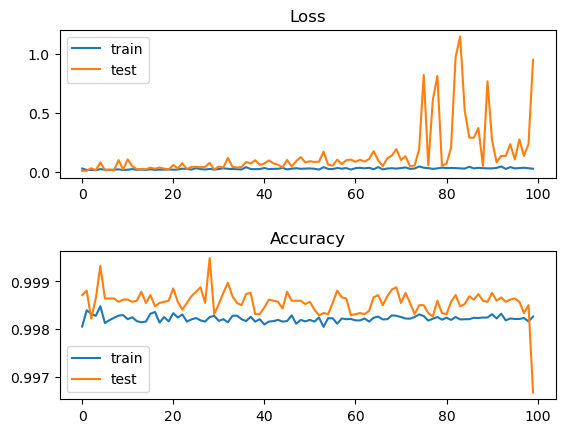

In [57]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(cnn1.history['loss'], label='train')
pyplot.plot(cnn1.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplots_adjust(hspace=0.5)
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(cnn1.history['accuracy'], label='train')
pyplot.plot(cnn1.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

#### CNN with early stopping

In [58]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=10)


In [59]:
cnn2 = cnn_best.fit(X_train3, y_train3, epochs=100, validation_data=(X_val3,y_val3), callbacks=[early_stopping_cnn])

Epoch 1/100
6233/6233 [==============================] - 34s 6ms/step - loss: 0.0256 - accuracy: 0.9982 - val_loss: 0.0978 - val_accuracy: 0.9987
Epoch 2/100
6233/6233 [==============================] - 35s 6ms/step - loss: 0.0341 - accuracy: 0.9983 - val_loss: 0.8083 - val_accuracy: 0.9986
Epoch 3/100
6233/6233 [==============================] - 35s 6ms/step - loss: 0.0228 - accuracy: 0.9982 - val_loss: 0.5268 - val_accuracy: 0.9986
Epoch 4/100
6233/6233 [==============================] - 36s 6ms/step - loss: 0.0387 - accuracy: 0.9983 - val_loss: 1.0243 - val_accuracy: 0.9985
Epoch 5/100
6233/6233 [==============================] - 35s 6ms/step - loss: 0.0233 - accuracy: 0.9983 - val_loss: 0.0951 - val_accuracy: 0.9985
Epoch 6/100
6233/6233 [==============================] - 35s 6ms/step - loss: 0.0405 - accuracy: 0.9983 - val_loss: 0.5827 - val_accuracy: 0.9988
Epoch 7/100
6233/6233 [==============================] - 34s 5ms/step - loss: 0.0240 - accuracy: 0.9983 - val_loss: 0.8940 -

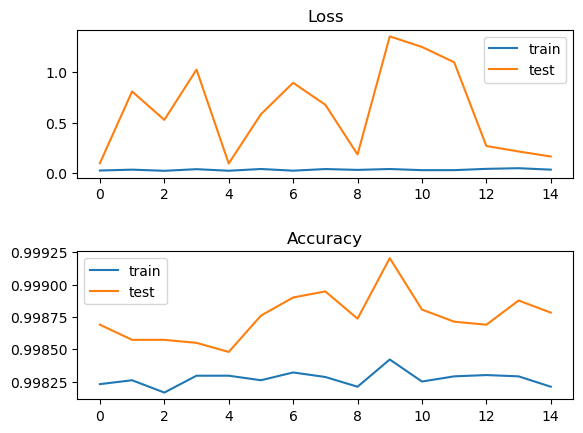

In [60]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(cnn2.history['loss'], label='train')
pyplot.plot(cnn2.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplots_adjust(hspace=0.5)
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(cnn2.history['accuracy'], label='train')
pyplot.plot(cnn2.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
cnn_best.save(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\CNN_output\cnn_best_gan_with_es.h5')
print("Saved model to disk")

Saved model to disk


In [68]:
X_test3.shape

(42737, 30, 1)

In [62]:
y_pred_cnn = cnn_best.predict(X_test3)

1336/1336 [==============================] - 2s 2ms/step


In [63]:
import numpy as np

def predict_classes(probs, threshold=0.5):

  classes = np.zeros_like(probs, dtype=int)
  classes[probs >= threshold] = 1
  return classes


In [64]:
preds = predict_classes(y_pred_cnn)

In [65]:
accuracy_cnn = accuracy_score(y_test3, preds)
precision_cnn = precision_score(y_test3, preds)
recall_cnn = recall_score(y_test3, preds)
f1_score_cnn = f1_score(y_test3, preds)
mcc_cnn = matthews_corrcoef(y_test3, preds)

print("Accuracy:", accuracy_cnn)
print("Precision:", precision_cnn)
print("F1-score:", f1_score_cnn)
print("Recall:", recall_cnn)
print("MCC:", mcc_cnn)

Accuracy: 0.9987598567985586
Precision: 0.9996911196911197
F1-score: 0.99795721719021
Recall: 0.9962293189688342
MCC: 0.9970699905599041


In [69]:
cm_cnn = confusion_matrix(y_test3, preds)
print(cm_cnn)

[[29738     4]
 [   49 12946]]


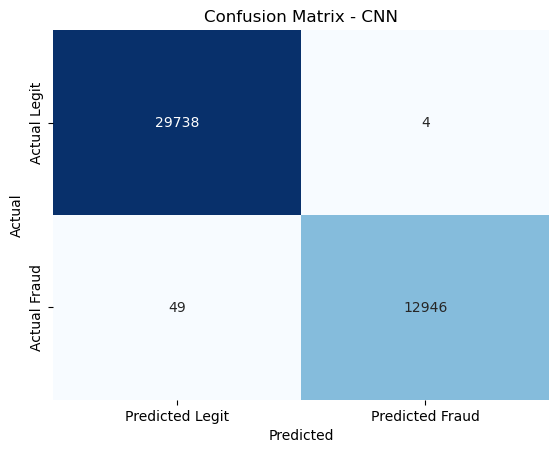

In [70]:
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Legit", "Predicted Fraud"],
            yticklabels=["Actual Legit", "Actual Fraud"])
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LSTM

In [72]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics

In [73]:
df_lstm = pd.read_csv(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\Data\Dataset03.csv')

In [74]:
df_lstm = df_lstm.drop('Unnamed: 0', axis=1)

In [75]:
df_lstm.shape

(284910, 31)

In [76]:
X = df_lstm.drop(['Class'], axis = 'columns')
Label_Data = df_lstm['Class']

In [77]:
X_r2 = StandardScaler().fit_transform(X)

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X_r2, Label_Data, test_size=0.3)

In [79]:
X_train.shape

(199437, 30)

In [80]:
X_val, X_test1, y_val, y_test1 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [81]:
# design network
np.random.seed(7)

train_LSTM_X=X_train
val_LSTM_X=X_val

## Reshape input to be 3D [samples, timesteps, features] (format requis par LSTM)
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
val_LSTM_X = val_LSTM_X.reshape((val_LSTM_X.shape[0], 1, val_LSTM_X.shape[1]))

train_LSTM_y=y_train
val_LSTM_y=y_val

test_LSTM_X = X_test1.reshape((X_test1.shape[0], 1, X_test1.shape[1]))

In [82]:
inputs = Input((1,30))
x1 = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs)
x2 = LSTM(50, dropout=0.3, recurrent_dropout=0.2)(x1)
outputs = Dense(1, activation='sigmoid')(x2)
model = Model(inputs, outputs)

In [83]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
lstm1 =model.fit(train_LSTM_X, train_LSTM_y,epochs=100, validation_data=(val_LSTM_X, val_LSTM_y))

Epoch 1/100
6233/6233 [==============================] - 17s 2ms/step - loss: 0.0309 - accuracy: 0.9898 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 2/100
6233/6233 [==============================] - 13s 2ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 3/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 4/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 5/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 6/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 7/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0027 -

In [85]:
# save model and architecture to single file
model.save(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\LSTM\lstm_Model_gan_without_es.h5')
print("Saved model to disk")

Saved model to disk


#### training with Early stopping

In [86]:
inputs = Input((1,30))
x1 = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs)
x2 = LSTM(50, dropout=0.3, recurrent_dropout=0.2)(x1)
outputs = Dense(1, activation='sigmoid')(x2)
model2 = Model(inputs, outputs)

In [87]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=10)

In [89]:
lstm2 = model2.fit(train_LSTM_X, train_LSTM_y, epochs=100, validation_data=(val_LSTM_X, val_LSTM_y), callbacks=[early_stopping_lstm])

Epoch 1/100
6233/6233 [==============================] - 18s 2ms/step - loss: 0.0299 - accuracy: 0.9897 - val_loss: 0.0032 - val_accuracy: 0.9995
Epoch 2/100
6233/6233 [==============================] - 13s 2ms/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0030 - val_accuracy: 0.9996
Epoch 3/100
6233/6233 [==============================] - 13s 2ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 4/100
6233/6233 [==============================] - 13s 2ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 5/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 6/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 7/100
6233/6233 [==============================] - 14s 2ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0028 -

In [90]:
# save model and architecture to single file
model2.save(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\LSTM\lstm_Model_gan_with_es.h5')
print("Saved model to disk")

Saved model to disk


In [91]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\LSTM\lstm_Model_gan_without_es.h5')
model2 = load_model(r'D:\Uni Docs\DSC4996\Dynamic_fraud_detection_system\LSTM\lstm_Model_gan_with_es.h5')
# summarize model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 30)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 50)             16200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 36,451
Trainable params: 36,451
Non-trainable params: 0
_________________________________________________________________


In [92]:
# evaluate the model
_, train_acc = model2.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model2.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.999, Test: 1.000


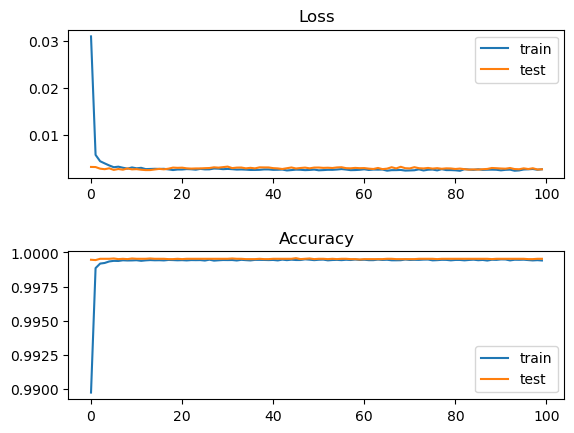

In [93]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(lstm1.history['loss'], label='train')
pyplot.plot(lstm1.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplots_adjust(hspace=0.5)
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(lstm1.history['accuracy'], label='train')
pyplot.plot(lstm1.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

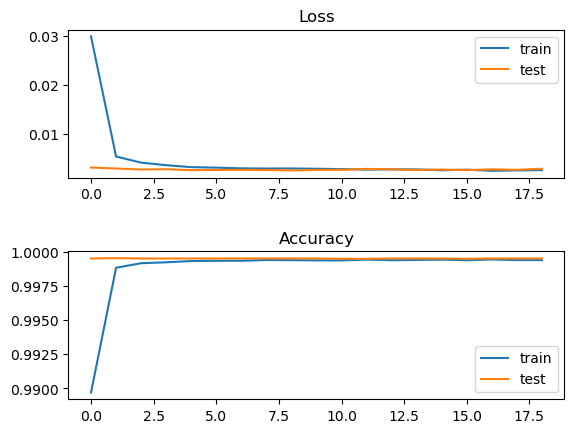

In [94]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(lstm2.history['loss'], label='train')
pyplot.plot(lstm2.history['val_loss'], label='test')
pyplot.legend()

pyplot.subplots_adjust(hspace=0.5)
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(lstm2.history['accuracy'], label='train')
pyplot.plot(lstm2.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


In [95]:
# predict probabilities for test set
yhat_probs = model2.predict(test_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

In [96]:
yhat_classes = (yhat_probs > 0.5).astype(int)

In [97]:
accuracy_lstm = accuracy_score(y_test1, yhat_classes)
print('Accuracy: %f' % accuracy_lstm)
precision_lstm = precision_score(y_test1, yhat_classes)
print('Precision: %f' % precision_lstm)
recall_lstm = recall_score(y_test1, yhat_classes)
print('Recall: %f' % recall_lstm)
f1_score_lstm = f1_score(y_test1, yhat_classes)
print('F1-Score: %f' % f1_score_lstm)
mcc_lstm = matthews_corrcoef(y_test1, yhat_classes)
print('MCC: %f' % mcc_lstm)


Accuracy: 0.999509
Precision: 0.999766
Recall: 0.998595
F1-Score: 0.999180
MCC: 0.998829


In [98]:
cm_lstm = confusion_matrix(y_test1, yhat_classes)

In [99]:
cm_lstm

array([[29925,     3],
       [   18, 12791]], dtype=int64)

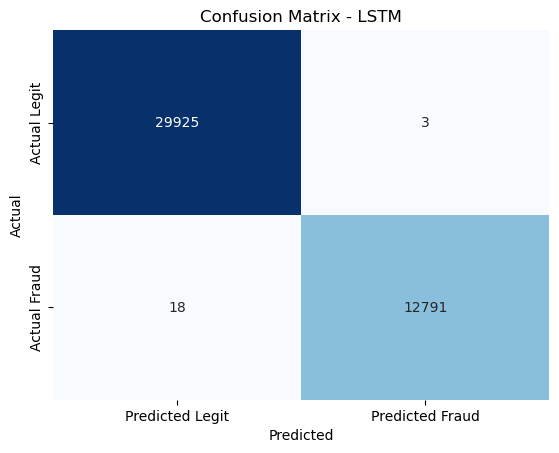

In [100]:
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Legit", "Predicted Fraud"],
            yticklabels=["Actual Legit", "Actual Fraud"])
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()